#### 1. Import relevant modules

In [43]:
from numpy.lib.function_base import average
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import functools
import itertools
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

#### 2. Load MNIST dataset and get the input and output dims

In [44]:
def load_dataset(batch_size):
    train_dataset = torchvision.datasets.MNIST(root='./data', 
                                            train=True, 
                                            transform=transforms.ToTensor(),  
                                            download=True)

    test_dataset = torchvision.datasets.MNIST(root='./data', 
                                            train=False, 
                                            transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    return train_loader, test_loader


def get_dims(data_loader):
    input_size = functools.reduce(lambda a, b: a*b, list(data_loader.dataset.data[0].shape))
    output_size = len(set(data_loader.dataset.targets.numpy()))
    return input_size, output_size

#### 3. Create Neural network class

In [45]:
class NeuralNet(nn.Module):
    def __init__(self, index, input_size, net, optimizer, lr):
        super(NeuralNet, self).__init__()

        self.index = index + 1
        self.input_size = input_size

        self.model = net

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)  

        self.losses = []
        self.predictions = []
    
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x

    def fit(self, data_loader, num_epochs=2):
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):  

                images = images.reshape(-1, self.input_size)
                
                outputs = self.forward(images)
                loss = self.criterion(outputs, labels)

                self.losses.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if (i+1) % data_loader.batch_size == 0:
                    print (f'model : {self.index}, Epoch [{epoch + 1} / {num_epochs}], Step [{i + 1} / {len(data_loader)}], Loss: {loss.item():.4f}')

    def evaluate(self, data_loader):
        with torch.no_grad():
            all_predictions = torch.tensor([])
            for images, labels in data_loader:
                images = images.reshape(-1, self.input_size)
                labels = labels
                outputs = self.forward(images)

                _, batch_predicted = torch.max(outputs.data, 1)
                all_predictions = torch.cat((all_predictions, batch_predicted), 0)

            self.y_true = data_loader.dataset.train_labels.numpy().astype(int)
            self.predictions = all_predictions.numpy().astype(int)

            self.accuracy = 100 * accuracy_score(self.y_true, self.predictions)

            print(f'model {self.index} results\n' \
                  f'accuracy  : {self.accuracy:.4f}\n')
            return self.accuracy



    def plot_results(self, fig_size=(24, 12)):
        f_beta = []
        labels_list = list(range(len(set(self.y_true))))
        conf_matrix = confusion_matrix(self.y_true, self.predictions, labels=labels_list)
        fig, ax = plt.subplots(figsize=fig_size)

        group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
        group_percentages = ["{0:.1%}".format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
        labels = np.asarray([f'{v1}\n\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]).reshape(len(labels_list), len(labels_list))
        sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"size": 16}, ax=ax)
        ax.set_title(f'Confusion Matrix for fnn Classifier (accuracy = {self.accuracy:.2f} %)\n', fontsize=16);
        ax.set_xlabel('Predicted Values\n', fontsize=20)
        ax.set_ylabel('Actual Values\n', fontsize=20);
        ax.xaxis.set_ticklabels(labels_list)
        ax.yaxis.set_ticklabels(labels_list)
        ax.tick_params(axis='both', labelsize=20)
        plt.show()

#### 4. Create fully connected nets and grid for different models

In [46]:
def create_net(input_size, hiddens, output_size, activation=nn.ReLU(), bias=True):
    layers = []
    list_layers = [input_size] + hiddens + [output_size]
    for i in range(len(hiddens)):
        layers.append(nn.Linear(list_layers[i], list_layers[i + 1], bias=bias))
        layers.append(activation)
    layers.append(nn.Linear(list_layers[-2], list_layers[-1], bias=bias))
    return nn.Sequential(*layers)


def models_grid(grid, input_size, output_size):
    models = []
    mod_grid = []
    for i, data in enumerate(itertools.product(*list(grid.values()))):
        hiddens,  activation, lr, optimizer = data
        net = create_net(input_size, hiddens, output_size, activation)
        models.append(NeuralNet(net=net, index=i, input_size=input_size, optimizer=optimizer, lr=lr))
        mod_grid.append({'hiddens': hiddens, 'activation': activation, 'lr': lr, 'optimizer': optimizer})
    return models, mod_grid

#### 5. Train and test our models, return the best model in terms of accuracy

In [47]:
def train_and_test_test_models(train_loader, test_loader, param_grid, epochs=5, plot=True):
    input_size, output_size = get_dims(train_loader)
    models, grids = models_grid(param_grid, input_size, output_size)
    best_model = None
    best_grid = None
    best_accuracy = 0
    for model, grid in zip(models, grids):
        train_loader, test_loader = load_dataset(batch_size=64)
        model.fit(data_loader=train_loader, num_epochs=epochs)
        current_accuracy = model.evaluate(test_loader)
        if current_accuracy > best_accuracy:
            best_model = model
            best_grid = grid
            best_accuracy = current_accuracy
        if plot:
            model.plot_results()
    print(f'best grid for dataset : {grid}')
    return model, grid

#### 6. run the code

model : 1, Epoch [1 / 3], Step [64 / 938], Loss: 0.3985
model : 1, Epoch [1 / 3], Step [128 / 938], Loss: 0.4415
model : 1, Epoch [1 / 3], Step [192 / 938], Loss: 0.2295
model : 1, Epoch [1 / 3], Step [256 / 938], Loss: 0.6612
model : 1, Epoch [1 / 3], Step [320 / 938], Loss: 0.1927
model : 1, Epoch [1 / 3], Step [384 / 938], Loss: 0.2827
model : 1, Epoch [1 / 3], Step [448 / 938], Loss: 0.6189
model : 1, Epoch [1 / 3], Step [512 / 938], Loss: 0.2086
model : 1, Epoch [1 / 3], Step [576 / 938], Loss: 0.5296
model : 1, Epoch [1 / 3], Step [640 / 938], Loss: 0.4650
model : 1, Epoch [1 / 3], Step [704 / 938], Loss: 0.3050
model : 1, Epoch [1 / 3], Step [768 / 938], Loss: 0.2182
model : 1, Epoch [1 / 3], Step [832 / 938], Loss: 0.5418
model : 1, Epoch [1 / 3], Step [896 / 938], Loss: 0.3229
model : 1, Epoch [2 / 3], Step [64 / 938], Loss: 0.2938
model : 1, Epoch [2 / 3], Step [128 / 938], Loss: 0.1785
model : 1, Epoch [2 / 3], Step [192 / 938], Loss: 0.7235
model : 1, Epoch [2 / 3], Step [2

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


model 1 results
accuracy  : 90.1400



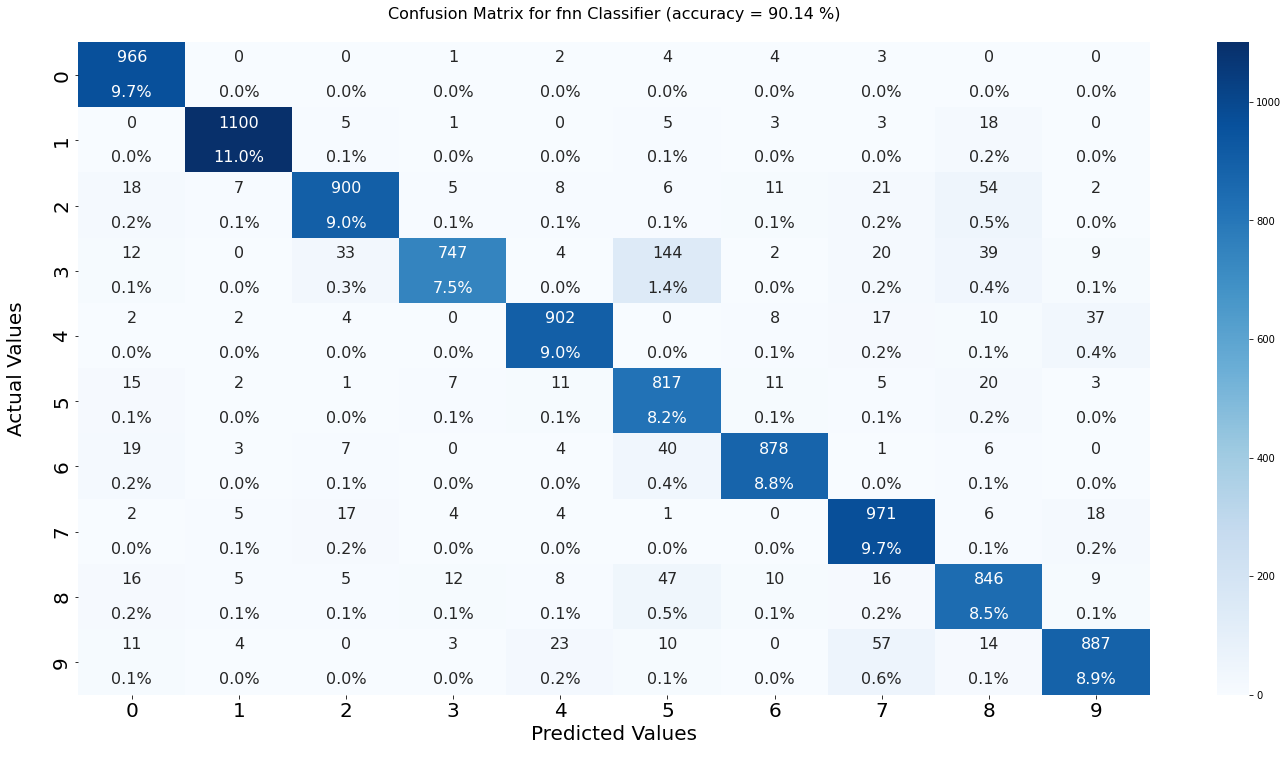

model : 2, Epoch [1 / 3], Step [64 / 938], Loss: 1.1230
model : 2, Epoch [1 / 3], Step [128 / 938], Loss: 0.8060
model : 2, Epoch [1 / 3], Step [192 / 938], Loss: 0.5235
model : 2, Epoch [1 / 3], Step [256 / 938], Loss: 0.4120
model : 2, Epoch [1 / 3], Step [320 / 938], Loss: 0.2714
model : 2, Epoch [1 / 3], Step [384 / 938], Loss: 0.3515
model : 2, Epoch [1 / 3], Step [448 / 938], Loss: 0.8025
model : 2, Epoch [1 / 3], Step [512 / 938], Loss: 0.5628
model : 2, Epoch [1 / 3], Step [576 / 938], Loss: 0.3542
model : 2, Epoch [1 / 3], Step [640 / 938], Loss: 0.1987
model : 2, Epoch [1 / 3], Step [704 / 938], Loss: 0.3504
model : 2, Epoch [1 / 3], Step [768 / 938], Loss: 0.3500
model : 2, Epoch [1 / 3], Step [832 / 938], Loss: 0.1904
model : 2, Epoch [1 / 3], Step [896 / 938], Loss: 0.4024
model : 2, Epoch [2 / 3], Step [64 / 938], Loss: 0.3476
model : 2, Epoch [2 / 3], Step [128 / 938], Loss: 0.2168
model : 2, Epoch [2 / 3], Step [192 / 938], Loss: 0.2957
model : 2, Epoch [2 / 3], Step [2

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


model 2 results
accuracy  : 94.7200



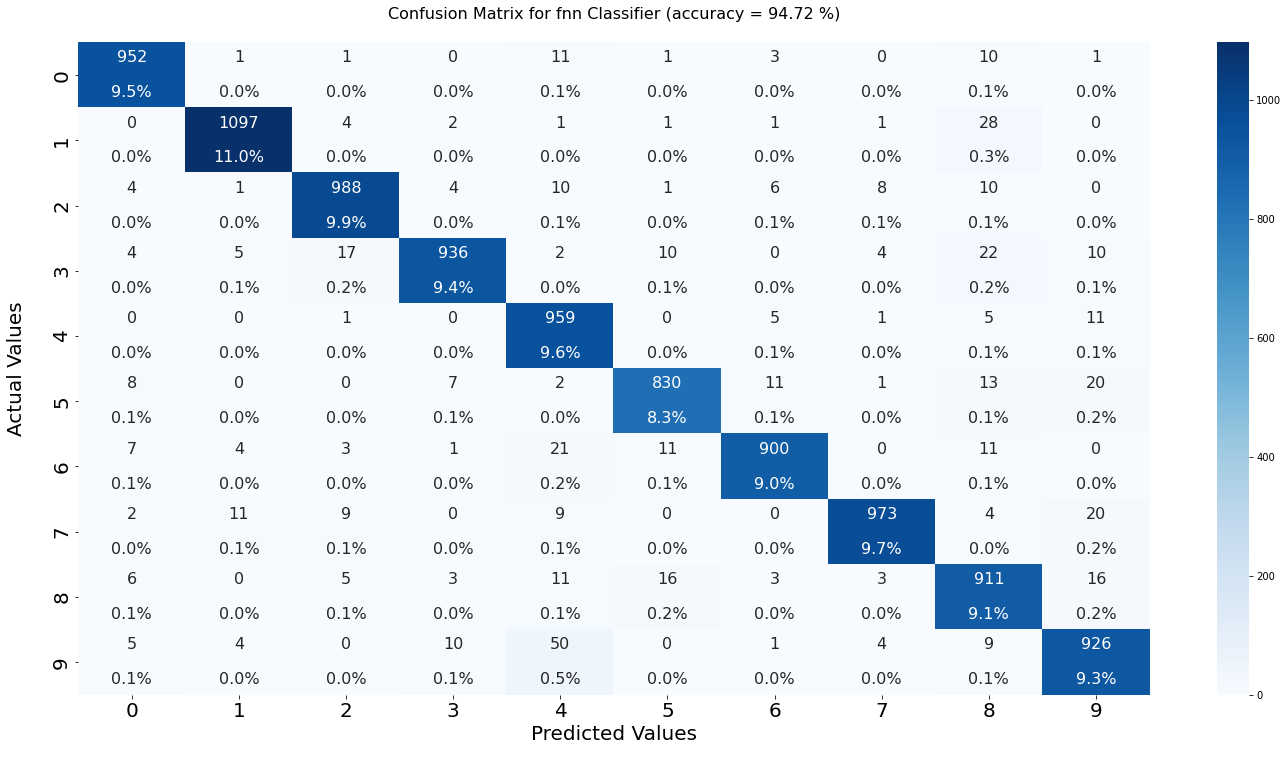

best grid for dataset : {'hiddens': [1000, 200, 100, 20], 'activation': ReLU(), 'lr': 0.02, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [48]:
param_grid = {'hiddens': [[], [20], [1000, 200, 100, 20]],
              'activation': [nn.ReLU(), nn.ELU()],
              'lr': [0.02],
              'optimizer': [torch.optim.Adam]}

param_grid = {'hiddens': [[], [1000, 200, 100, 20]],
              'activation': [nn.ReLU()],
              'lr': [0.02],
              'optimizer': [torch.optim.Adam]}


train_loader, test_loader = load_dataset(batch_size=64)
best_model, _ = train_and_test_test_models(train_loader, test_loader, param_grid, epochs=3, plot=True)

#### 7. Plot the bese model

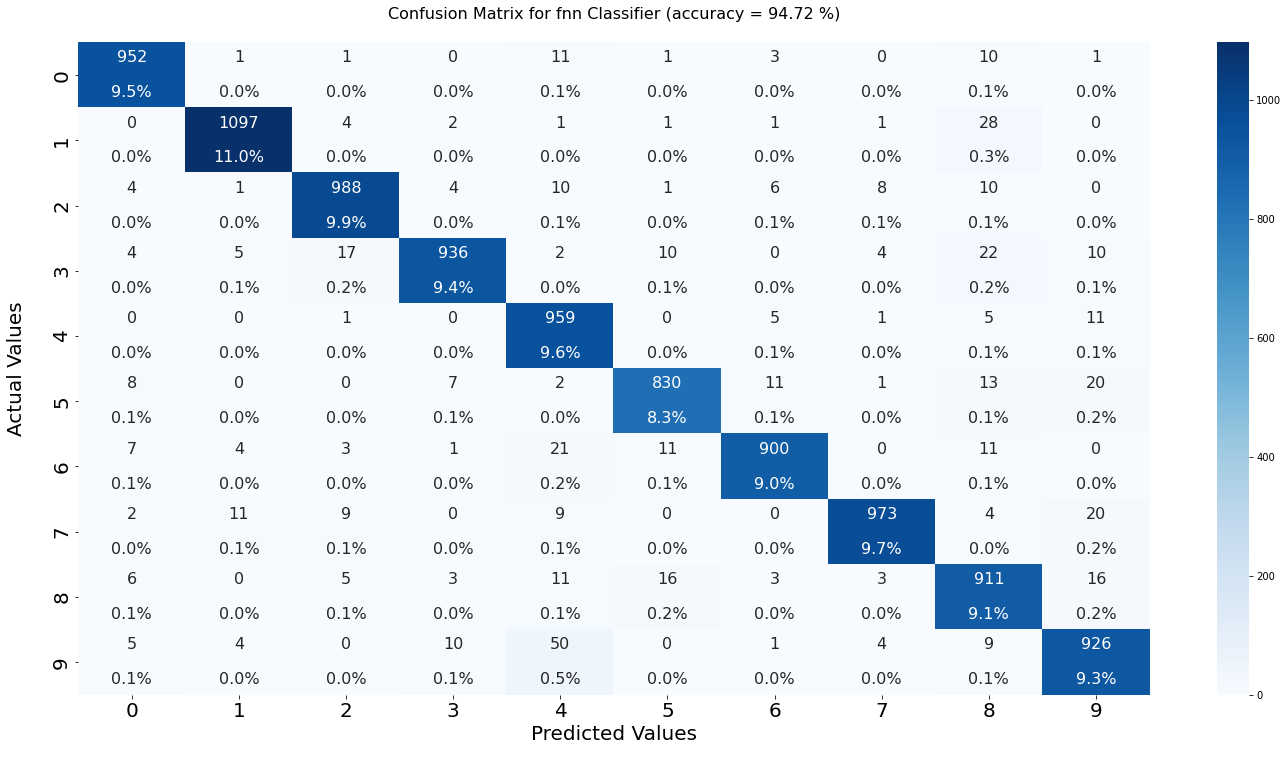

In [50]:
best_model.plot_results()